# Connecting To Data

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
df=pd.read_csv("loan_events_25k.csv")
df.head()

,event_id,loan_date,branch_id,officer_id,product_type,amount_ngn,credit_score,tenure_months,branch_name,default_flag,loss_ngn
0,E00001,2025-07-17 22:00:00,BR-003,OFF-018,SME Loan,3563950,319.0,12,Abuja North,Yes,1.935476e+06
1,E00002,2025-07-06 20:00:00,BR-004,OFF-007,Mortgage,2750992,420.0,12,Kano Central,Yes,1.493982e+06
2,E00003,2025-07-24 22:00:00,BR-002,OFF-013,Personal Loan,7853698,823.0,36,Onitsha Branch,No,0.000000e+00
3,E00004,2025-07-18 02:00:00,BR-005,OFF-003,Personal Loan,8047409,821.0,36,Port Harcourt,No,0.000000e+00
4,E00005,2025-07-16 15:00:00,BR-005,OFF-003,SME Loan,7590331,682.0,6,Port Harcourt,No,0.000000e+00


# Data Profiling & Quality Check

In [33]:
#------- Basic Structure
print(df.info())

#--- Check for Missing Values
print("\nMissing Values per Column:")
print(df.isna().sum())

#---Check For Duplicate Values
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

#--Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe(include='number').T)

#--Categorical Distribution (for branch, product type, officer, default_flag,)
for col in ["branch_id", "branch_name", "product_type", "officer_id", "default_flag"]:
    df[col].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25100 entries, 0 to 25099
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_id       25100 non-null  object 
 1   loan_date      25100 non-null  object 
 2   branch_id      25100 non-null  object 
 3   officer_id     25100 non-null  object 
 4   product_type   25100 non-null  object 
 5   amount_ngn     25100 non-null  int64  
 6   credit_score   24800 non-null  float64
 7   tenure_months  25100 non-null  int64  
 8   branch_name    25100 non-null  object 
 9   default_flag   25100 non-null  object 
 10  loss_ngn       25100 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 2.1+ MB
None

Missing Values per Column:
event_id           0
loan_date          0
branch_id          0
officer_id         0
product_type       0
amount_ngn         0
credit_score     300
tenure_months      0
branch_name        0
default_flag       0
loss_ngn      

# Data Cleaning

In [34]:
#--Standardize product type Column
df["product_type"]=df["product_type"].replace("sme_loan","SME Loan")

# Fill missing credit scores with median
df["credit_score"]=df["credit_score"].fillna(df["credit_score"].median())

#--flag invalid Loan amount 0
df["Invalid Amount"]=np.where(df["amount_ngn"] <=0,1,0)

# -Remove duplicates event_id
df=df.drop_duplicates()

# Change Loan Date Datatype to datetime
df["loan_date"]=pd.to_datetime(df["loan_date"])

# Extract date feature
df["Month"]=df["loan_date"].dt.month_name()
df["Year"]=df["loan_date"].dt.year
df["weekdays"]=df["loan_date"].dt.weekday

# Exploratory Data Analysis(EDA)

In [35]:
#--Distribution of Defaults 
# Overall default distribution
default_proportion=(df["default_flag"].value_counts(normalize=True) * 100)

# Defaults by product
defaults_by_product = df.groupby("product_type")["default_flag"].value_counts(normalize=True).unstack()* 100

# Defaults by Branch
default_by_branch=df.groupby("branch_name")["default_flag"].value_counts(normalize=True).unstack()*100


In [36]:
default_proportion.reset_index()

,default_flag,proportion
0,No,63.28
1,Yes,36.72


In [37]:
defaults_by_product.reset_index()

default_flag,product_type,No,Yes
0,Agribusiness,62.970219,37.029781
1,Mortgage,64.990951,35.009049
2,Personal Loan,62.428899,37.571101
3,SME Loan,63.388785,36.611215


In [38]:
default_by_branch.reset_index()

default_flag,branch_name,No,Yes
0,Abuja North,62.762945,37.237055
1,Kano Central,62.350870,37.649130
2,Lagos HQ,64.795708,35.204292
3,Onitsha Branch,63.127258,36.872742
4,Port Harcourt,63.421310,36.578690


# Pareto Analysis (80/20 Rule)

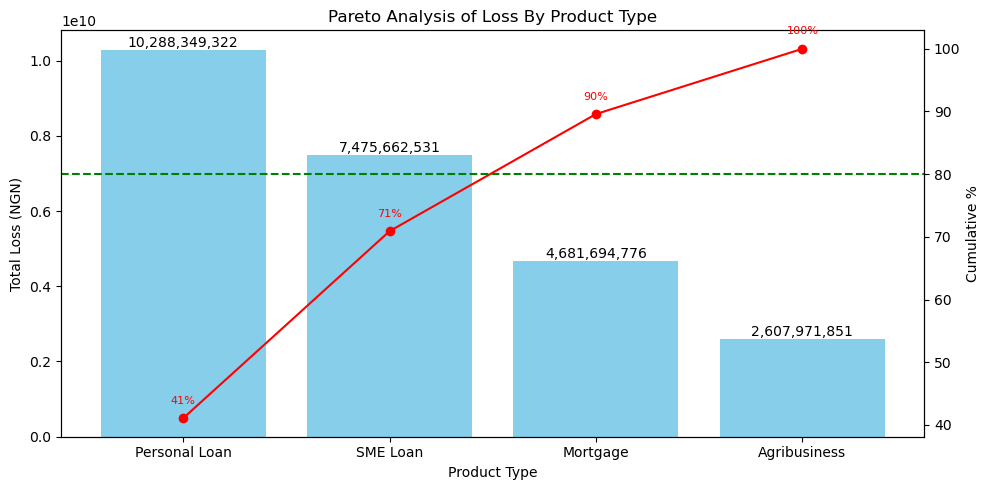

In [39]:
# Loss by product
loss_by_product = df.groupby("product_type")["loss_ngn"].sum().sort_values(ascending=False)

# pareto cumunlative %
pareto_cum=(loss_by_product.cumsum()/loss_by_product.sum())*100

# plot bar chart
plt.figure(figsize=(10,5))
bars=plt.bar(loss_by_product.index,loss_by_product.values,color="skyblue")
plt.ylabel("Total Loss (NGN)")
plt.xlabel("Product Type")

# add data label
for i,v in enumerate(loss_by_product.values):
    plt.text(i,v,f"{int(v):,}",ha="center",va="bottom")

# cumulative %
plt.twinx()
plt.plot(pareto_cum.index,pareto_cum.values,marker="o",color="red")
plt.ylabel("Cumulative %")

for i,v in enumerate(pareto_cum.values):
    plt.text(i, v+2, f"{v:.0f}%",ha="center",va="bottom",fontsize=8,color="red",)
# cumulative line
plt.axhline(80, color="green", linestyle="--")

# Title
plt.title("Pareto Analysis of Loss By Product Type")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

#### How Does Product Type Contribute to The Loss ?

### Which Officers Contribute Most to the Loss?

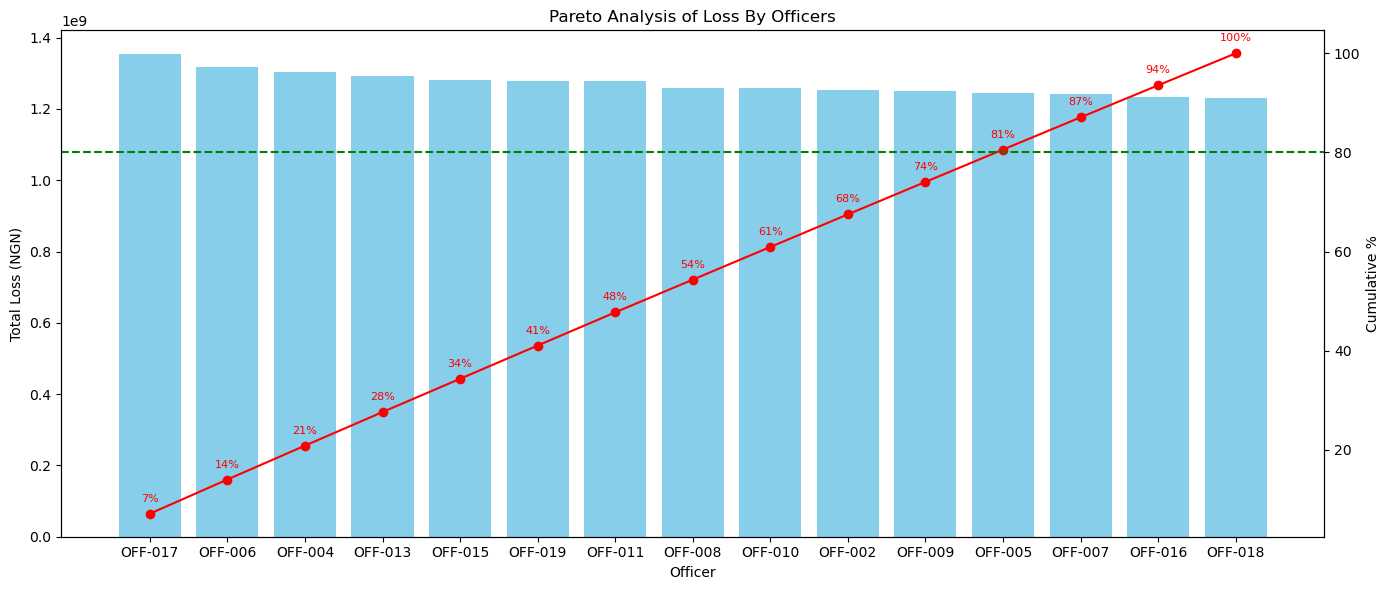

In [40]:
# Loss by officer
loss_by_officer = df.groupby("officer_id")["loss_ngn"].sum().sort_values(ascending=False).head(15)

# pareto cumulative %
pareto_officer_cum=(loss_by_officer.cumsum()/loss_by_officer.sum())*100

plt.figure(figsize=(14,6))
# plot bar chart
bars=plt.bar(loss_by_officer.index,loss_by_officer.values,color="skyblue")
plt.ylabel("Total Loss (NGN)")
plt.xlabel("Officer")
    
# cummulative line
plt.twinx()
plt.plot(pareto_officer_cum.index,pareto_officer_cum.values,marker="o",color="red")
plt.ylabel("Cumulative %")

for i, v in enumerate(pareto_officer_cum.values):
    plt.text(i,v+2,f"{v:.0f}%",ha="center",va="bottom",fontsize=8,color="red")

plt.axhline(80, color="green",linestyle="--")

# Title
plt.title("Pareto Analysis of Loss By Officers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



### Which Branches Are Driving the Highest Losses?

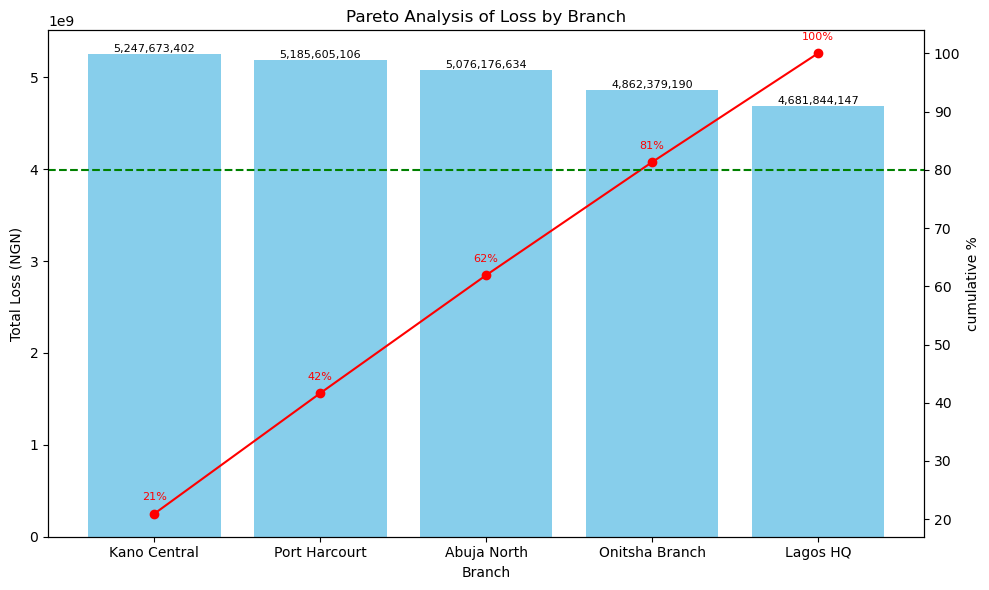

In [41]:
# loss by Branch
loss_by_branch=df.groupby("branch_name")["loss_ngn"].sum().sort_values(ascending=False)


# 2. Calculate cumulative percentage
cum_percent = loss_by_branch.cumsum() / loss_by_branch.sum() * 100

# 3. Create figure
plt.figure(figsize=(10,6))

# --- Bar chart ---
bars = plt.bar(loss_by_branch.index, loss_by_branch.values, color="skyblue")
plt.ylabel("Total Loss (NGN)")
plt.xlabel("Branch")

# add data label
for i,v in enumerate(loss_by_branch.values):
    plt.text(i,v, f"{int(v):,}",ha='center',va='bottom',fontsize=8)

# cumulative line
plt.twinx()
plt.plot(cum_percent.index,cum_percent.values, marker="o",color="red")
plt.ylabel("cumulative %")

for i, v in enumerate(cum_percent.values):
    plt.text(i, v+2, f"{v:.0f}%", ha="center", va="bottom", fontsize=8, color="red")
# Add 80% reference line
plt.axhline(80, color="green", linestyle="--")

# Title
plt.title("Pareto Analysis of Loss by Branch")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Statistical Root Cause Analysis Test

# 1. T-Test: Credit Score vs Default Status


### Are the credit scores of defaulted borrowers significantly different from those of non-defaulters?

In [42]:
from scipy.stats import ttest_ind

# Group Credit Score By Defaulters And Non-Defaulter
default_scores=df.loc[df["default_flag"]=="Yes","credit_score"].dropna()
non_default_scores=df.loc[df["default_flag"]=="No","credit_score"].dropna()

# T-test for mean difference
t_stat, p_value = ttest_ind(default_scores, non_default_scores, equal_var=False)
alpha = 0.05
if p_value < alpha:
    print("Reject H0: Credit scores differ significantly between defaulters and non-defaulters.")
else:
    print("Fail to Reject H0: No significant difference in credit scores.")

Reject H0: Credit scores differ significantly between defaulters and non-defaulters.


In [43]:
print("Mean Credit Score (Defaulters):", round(default_scores.mean(), 2))
print("Mean Credit Score (Non-Defaulters):", round(non_default_scores.mean(), 2))


Mean Credit Score (Defaulters): 402.4
Mean Credit Score (Non-Defaulters): 673.31


## 2.Chi-square test (Defaults vs Categorical Variables)



## Test whether branch, product, or officer distribution is independent of default.

In [44]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi_square_test(df, category_col, target_col="default_flag"):
    # Create contingency table
    contingency = pd.crosstab(df[category_col], df[target_col])
    
    # Run Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    print(f"\nChi-Square Test: {category_col} vs {target_col}")
    print("Chi2 Statistic:", chi2)
    print("Degrees of Freedom:", dof)
    print("P-Value:", p)
    
    if p < 0.05:
        print(f" Reject H0 → {category_col} is associated with {target_col}")
    else:
        print(f"Fail to Reject H0 → No significant association between {category_col} and {target_col}")


chi_square_test(df, "branch_name")
chi_square_test(df, "product_type")
chi_square_test(df, "officer_id")



Chi-Square Test: branch_name vs default_flag
Chi2 Statistic: 7.353605461269473
Degrees of Freedom: 4
P-Value: 0.11834064026157039
Fail to Reject H0 → No significant association between branch_name and default_flag

Chi-Square Test: product_type vs default_flag
Chi2 Statistic: 9.532355322943555
Degrees of Freedom: 3
P-Value: 0.022989633630516162
 Reject H0 → product_type is associated with default_flag

Chi-Square Test: officer_id vs default_flag
Chi2 Statistic: 9.05160172124977
Degrees of Freedom: 19
P-Value: 0.9726124897617324
Fail to Reject H0 → No significant association between officer_id and default_flag
